In [1]:
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

In [2]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

In [3]:
tf.__version__

'2.8.0'

## Load data

In [4]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):

    nfeatures = 10
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

## Train GAMI-Net 

In [5]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 2, subnet_arch=[40] * 2,
                batch_size=1000, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.001, 0.001, 0.001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                verbose=True, val_ratio=0.2, random_state=random_state)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                          np.round(get_metric(val_y, pred_val),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.06453, val loss: 0.06025
Main effects training epoch: 2, train loss: 0.02400, val loss: 0.02104
Main effects training epoch: 3, train loss: 0.02247, val loss: 0.02071
Main effects training epoch: 4, train loss: 0.02453, val loss: 0.02295
Main effects training epoch: 5, train loss: 0.01919, val loss: 0.01711
Main effects training epoch: 6, train loss: 0.01868, val loss: 0.01624
Main effects training epoch: 7, train loss: 0.01864, val loss: 0.01617
Main effects training epoch: 8, train loss: 0.01757, val loss: 0.01531
Main effects training epoch: 9, train loss: 0.01710, val loss: 0.01505
Main effects training epoch: 10, train loss: 0.01678, val loss: 0.01481
Main effects training epoch: 11, train loss: 0.01627, val loss: 0.01428
Main effects training epoch: 12, train loss: 0.01592, val loss: 0.01392
Main effects training e

Main effects training epoch: 119, train loss: 0.01070, val loss: 0.00991
Main effects training epoch: 120, train loss: 0.01061, val loss: 0.00985
Main effects training epoch: 121, train loss: 0.01057, val loss: 0.00981
Main effects training epoch: 122, train loss: 0.01055, val loss: 0.00980
Main effects training epoch: 123, train loss: 0.01057, val loss: 0.00982
Main effects training epoch: 124, train loss: 0.01058, val loss: 0.00984
Main effects training epoch: 125, train loss: 0.01052, val loss: 0.00980
Main effects training epoch: 126, train loss: 0.01051, val loss: 0.00979
Main effects training epoch: 127, train loss: 0.01051, val loss: 0.00978
Main effects training epoch: 128, train loss: 0.01050, val loss: 0.00979
Main effects training epoch: 129, train loss: 0.01048, val loss: 0.00978
Main effects training epoch: 130, train loss: 0.01051, val loss: 0.00981
Main effects training epoch: 131, train loss: 0.01051, val loss: 0.00982
Main effects training epoch: 132, train loss: 0.010

Interaction training epoch: 26, train loss: 0.00561, val loss: 0.00547
Interaction training epoch: 27, train loss: 0.00557, val loss: 0.00545
Interaction training epoch: 28, train loss: 0.00543, val loss: 0.00531
Interaction training epoch: 29, train loss: 0.00535, val loss: 0.00527
Interaction training epoch: 30, train loss: 0.00524, val loss: 0.00516
Interaction training epoch: 31, train loss: 0.00519, val loss: 0.00513
Interaction training epoch: 32, train loss: 0.00512, val loss: 0.00508
Interaction training epoch: 33, train loss: 0.00511, val loss: 0.00506
Interaction training epoch: 34, train loss: 0.00502, val loss: 0.00495
Interaction training epoch: 35, train loss: 0.00498, val loss: 0.00496
Interaction training epoch: 36, train loss: 0.00492, val loss: 0.00487
Interaction training epoch: 37, train loss: 0.00487, val loss: 0.00485
Interaction training epoch: 38, train loss: 0.00485, val loss: 0.00482
Interaction training epoch: 39, train loss: 0.00481, val loss: 0.00480
Intera

Interaction training epoch: 142, train loss: 0.00358, val loss: 0.00373
Interaction training epoch: 143, train loss: 0.00363, val loss: 0.00377
Interaction training epoch: 144, train loss: 0.00341, val loss: 0.00354
Interaction training epoch: 145, train loss: 0.00335, val loss: 0.00352
Interaction training epoch: 146, train loss: 0.00338, val loss: 0.00354
Interaction training epoch: 147, train loss: 0.00334, val loss: 0.00350
Interaction training epoch: 148, train loss: 0.00338, val loss: 0.00357
Interaction training epoch: 149, train loss: 0.00337, val loss: 0.00356
Interaction training epoch: 150, train loss: 0.00336, val loss: 0.00354
Interaction training epoch: 151, train loss: 0.00331, val loss: 0.00349
Interaction training epoch: 152, train loss: 0.00333, val loss: 0.00348
Interaction training epoch: 153, train loss: 0.00335, val loss: 0.00350
Interaction training epoch: 154, train loss: 0.00340, val loss: 0.00356
Interaction training epoch: 155, train loss: 0.00329, val loss: 

Interaction training epoch: 256, train loss: 0.00235, val loss: 0.00256
Interaction training epoch: 257, train loss: 0.00234, val loss: 0.00253
Interaction training epoch: 258, train loss: 0.00228, val loss: 0.00246
Interaction training epoch: 259, train loss: 0.00229, val loss: 0.00247
Interaction training epoch: 260, train loss: 0.00227, val loss: 0.00244
Interaction training epoch: 261, train loss: 0.00229, val loss: 0.00246
Interaction training epoch: 262, train loss: 0.00228, val loss: 0.00247
Interaction training epoch: 263, train loss: 0.00223, val loss: 0.00241
Interaction training epoch: 264, train loss: 0.00224, val loss: 0.00242
Interaction training epoch: 265, train loss: 0.00225, val loss: 0.00243
Interaction training epoch: 266, train loss: 0.00226, val loss: 0.00244
Interaction training epoch: 267, train loss: 0.00225, val loss: 0.00243
Interaction training epoch: 268, train loss: 0.00220, val loss: 0.00238
Interaction training epoch: 269, train loss: 0.00223, val loss: 

Interaction training epoch: 371, train loss: 0.00196, val loss: 0.00211
Interaction training epoch: 372, train loss: 0.00205, val loss: 0.00223
Interaction training epoch: 373, train loss: 0.00201, val loss: 0.00216
Interaction training epoch: 374, train loss: 0.00196, val loss: 0.00213
Interaction training epoch: 375, train loss: 0.00196, val loss: 0.00211
Interaction training epoch: 376, train loss: 0.00193, val loss: 0.00209
Interaction training epoch: 377, train loss: 0.00193, val loss: 0.00211
Interaction training epoch: 378, train loss: 0.00194, val loss: 0.00210
Interaction training epoch: 379, train loss: 0.00191, val loss: 0.00209
Interaction training epoch: 380, train loss: 0.00192, val loss: 0.00208
Interaction training epoch: 381, train loss: 0.00191, val loss: 0.00210
Interaction training epoch: 382, train loss: 0.00194, val loss: 0.00209
Interaction training epoch: 383, train loss: 0.00204, val loss: 0.00225
Interaction training epoch: 384, train loss: 0.00202, val loss: 

Interaction training epoch: 486, train loss: 0.00186, val loss: 0.00207
Interaction training epoch: 487, train loss: 0.00192, val loss: 0.00208
Interaction training epoch: 488, train loss: 0.00190, val loss: 0.00208
Interaction training epoch: 489, train loss: 0.00183, val loss: 0.00200
Interaction training epoch: 490, train loss: 0.00186, val loss: 0.00203
Interaction training epoch: 491, train loss: 0.00188, val loss: 0.00205
Interaction training epoch: 492, train loss: 0.00184, val loss: 0.00202
Interaction training epoch: 493, train loss: 0.00186, val loss: 0.00202
Interaction training epoch: 494, train loss: 0.00184, val loss: 0.00203
Interaction training epoch: 495, train loss: 0.00185, val loss: 0.00200
Interaction training epoch: 496, train loss: 0.00185, val loss: 0.00203
Interaction training epoch: 497, train loss: 0.00185, val loss: 0.00203
Interaction training epoch: 498, train loss: 0.00182, val loss: 0.00201
Interaction training epoch: 499, train loss: 0.00187, val loss: 

Fine tuning epoch: 115, train loss: 0.00202, val loss: 0.00211
Fine tuning epoch: 116, train loss: 0.00196, val loss: 0.00200
Fine tuning epoch: 117, train loss: 0.00207, val loss: 0.00214
Fine tuning epoch: 118, train loss: 0.00206, val loss: 0.00213
Fine tuning epoch: 119, train loss: 0.00201, val loss: 0.00207
Fine tuning epoch: 120, train loss: 0.00209, val loss: 0.00213
Fine tuning epoch: 121, train loss: 0.00203, val loss: 0.00211
Fine tuning epoch: 122, train loss: 0.00191, val loss: 0.00195
Fine tuning epoch: 123, train loss: 0.00195, val loss: 0.00200
Fine tuning epoch: 124, train loss: 0.00193, val loss: 0.00199
Fine tuning epoch: 125, train loss: 0.00191, val loss: 0.00196
Fine tuning epoch: 126, train loss: 0.00191, val loss: 0.00198
Fine tuning epoch: 127, train loss: 0.00190, val loss: 0.00196
Fine tuning epoch: 128, train loss: 0.00194, val loss: 0.00198
Fine tuning epoch: 129, train loss: 0.00200, val loss: 0.00206
Fine tuning epoch: 130, train loss: 0.00192, val loss: 

## Visualization

In [6]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

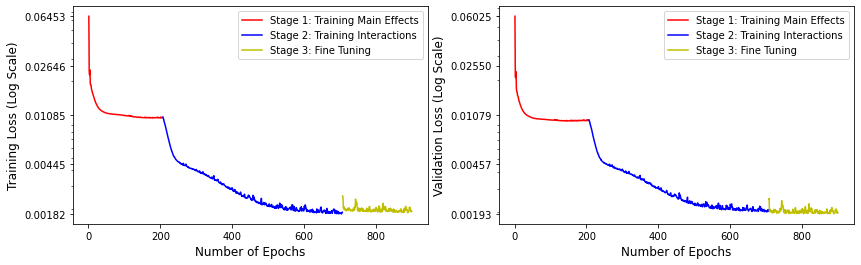

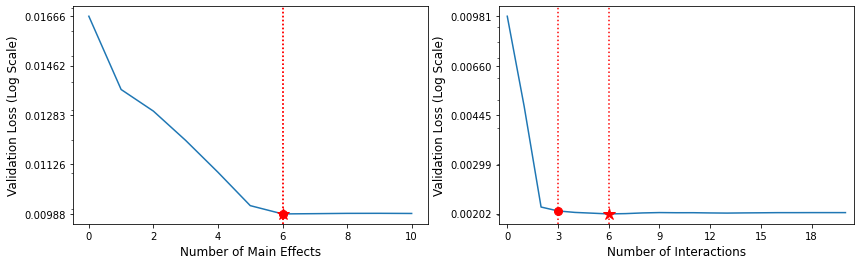

In [7]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

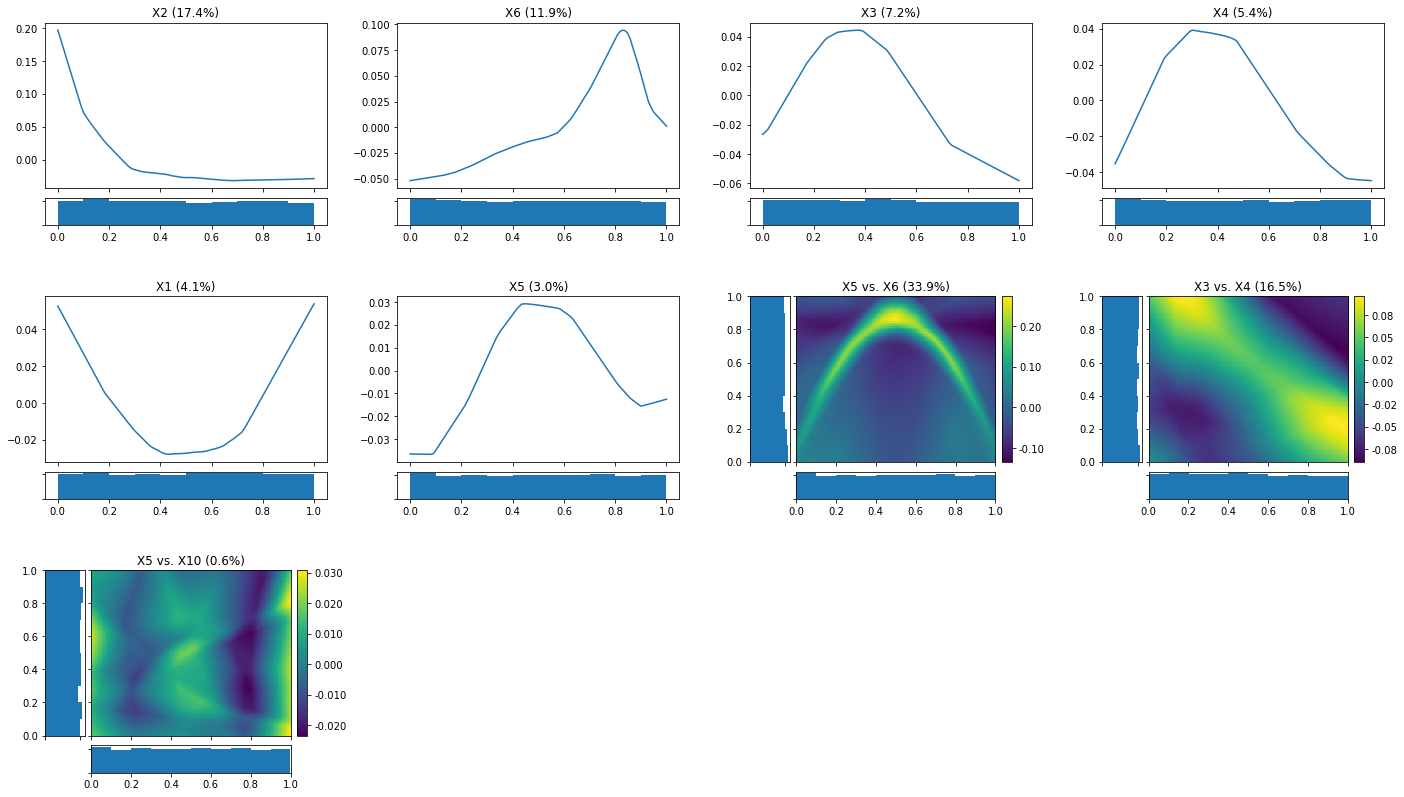

In [8]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')

Feature Importance

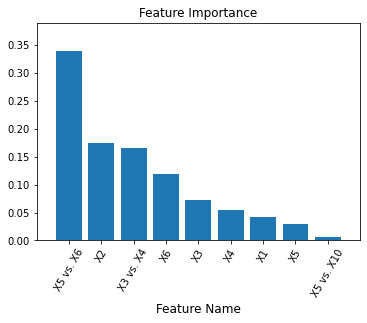

In [9]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [10]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

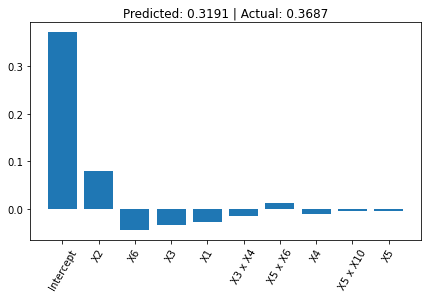

In [11]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

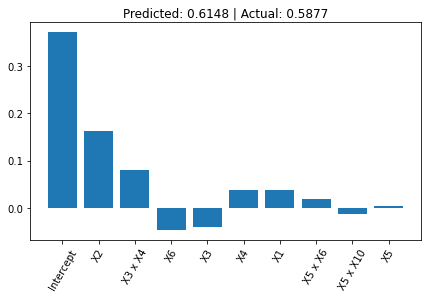

In [12]:
local_visualize(data_dict_local[1], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [13]:
model.save(folder="./", name="model_saved")

In [14]:
## The reloaded model should not be refit again
modelnew = GAMINet(meta_info={})
modelnew.load(folder="./", name="model_saved")

# Shape constraints

In [ ]:
model_debug = GAMINet(meta_info=meta_info, interact_num=0, 
                interact_arch=[40] * 2, subnet_arch=[40] * 2, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.001, 0.001, 0.001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                convex_list=[0, 1], mono_decreasing_list=[1], lattice_size=2, calibration_size=10,
                include_interaction_list=[(2, 3), (4, 5)],
                # manually inputted interactions are included in addition to prescreening interactions defined by interact_num.
                ## Model with Convexity Constraints are generally hard to train, try larger learning rates.
                verbose=True, val_ratio=0.2, random_state=random_state)
model_debug.fit(train_x, train_y)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.03171, val loss: 0.02994
Main effects training epoch: 2, train loss: 0.02274, val loss: 0.02142
Main effects training epoch: 3, train loss: 0.01830, val loss: 0.01732
Main effects training epoch: 4, train loss: 0.01585, val loss: 0.01479
Main effects training epoch: 5, train loss: 0.01463, val loss: 0.01373
Main effects training epoch: 6, train loss: 0.01387, val loss: 0.01294
Main effects training epoch: 7, train loss: 0.01344, val loss: 0.01254
Main effects training epoch: 8, train loss: 0.01291, val loss: 0.01194
Main effects training epoch: 9, train loss: 0.01264, val loss: 0.01177
Main effects training epoch: 10, train loss: 0.01287, val loss: 0.01201
Main effects training epoch: 11, train loss: 0.01202, val loss: 0.01122
Main effects training epoch: 12, train loss: 0.01184, val loss: 0.01106
Main effects training e

Main effects training epoch: 115, train loss: 0.01069, val loss: 0.01032
Main effects training epoch: 116, train loss: 0.01069, val loss: 0.01026
Main effects training epoch: 117, train loss: 0.01079, val loss: 0.01041
Main effects training epoch: 118, train loss: 0.01075, val loss: 0.01039
Main effects training epoch: 119, train loss: 0.01089, val loss: 0.01058
Main effects training epoch: 120, train loss: 0.01068, val loss: 0.01031
Main effects training epoch: 121, train loss: 0.01073, val loss: 0.01034
Main effects training epoch: 122, train loss: 0.01070, val loss: 0.01031
Main effects training epoch: 123, train loss: 0.01071, val loss: 0.01033
Main effects training epoch: 124, train loss: 0.01071, val loss: 0.01031
Main effects training epoch: 125, train loss: 0.01069, val loss: 0.01034
Main effects training epoch: 126, train loss: 0.01068, val loss: 0.01025
Main effects training epoch: 127, train loss: 0.01078, val loss: 0.01037
Main effects training epoch: 128, train loss: 0.010

Main effects training epoch: 228, train loss: 0.01062, val loss: 0.01020
Main effects training epoch: 229, train loss: 0.01064, val loss: 0.01025
Main effects training epoch: 230, train loss: 0.01081, val loss: 0.01045
Main effects training epoch: 231, train loss: 0.01059, val loss: 0.01018
Main effects training epoch: 232, train loss: 0.01055, val loss: 0.01016
Main effects training epoch: 233, train loss: 0.01057, val loss: 0.01016
Main effects training epoch: 234, train loss: 0.01065, val loss: 0.01024
Main effects training epoch: 235, train loss: 0.01056, val loss: 0.01011
Main effects training epoch: 236, train loss: 0.01058, val loss: 0.01019
Main effects training epoch: 237, train loss: 0.01063, val loss: 0.01024
Main effects training epoch: 238, train loss: 0.01060, val loss: 0.01021
Main effects training epoch: 239, train loss: 0.01064, val loss: 0.01022
Main effects training epoch: 240, train loss: 0.01056, val loss: 0.01017
Main effects training epoch: 241, train loss: 0.010

Main effects training epoch: 342, train loss: 0.01036, val loss: 0.00987
Main effects training epoch: 343, train loss: 0.01039, val loss: 0.00987
Main effects training epoch: 344, train loss: 0.01033, val loss: 0.00980
Main effects training epoch: 345, train loss: 0.01046, val loss: 0.00999
Main effects training epoch: 346, train loss: 0.01036, val loss: 0.00983
Main effects training epoch: 347, train loss: 0.01030, val loss: 0.00982
Main effects training epoch: 348, train loss: 0.01030, val loss: 0.00978
Main effects training epoch: 349, train loss: 0.01031, val loss: 0.00979
Main effects training epoch: 350, train loss: 0.01031, val loss: 0.00980
Main effects training epoch: 351, train loss: 0.01045, val loss: 0.00992
Main effects training epoch: 352, train loss: 0.01032, val loss: 0.00982
Main effects training epoch: 353, train loss: 0.01029, val loss: 0.00982
Main effects training epoch: 354, train loss: 0.01043, val loss: 0.00990
Main effects training epoch: 355, train loss: 0.010

Interaction training epoch: 33, train loss: 0.00317, val loss: 0.00314
Interaction training epoch: 34, train loss: 0.00304, val loss: 0.00303
Interaction training epoch: 35, train loss: 0.00303, val loss: 0.00298
Interaction training epoch: 36, train loss: 0.00301, val loss: 0.00293
Interaction training epoch: 37, train loss: 0.00289, val loss: 0.00285
Interaction training epoch: 38, train loss: 0.00293, val loss: 0.00285
Interaction training epoch: 39, train loss: 0.00278, val loss: 0.00274
Interaction training epoch: 40, train loss: 0.00279, val loss: 0.00276
Interaction training epoch: 41, train loss: 0.00274, val loss: 0.00267
Interaction training epoch: 42, train loss: 0.00279, val loss: 0.00276
Interaction training epoch: 43, train loss: 0.00285, val loss: 0.00283
Interaction training epoch: 44, train loss: 0.00257, val loss: 0.00255
Interaction training epoch: 45, train loss: 0.00263, val loss: 0.00256
Interaction training epoch: 46, train loss: 0.00250, val loss: 0.00247
Intera

In [ ]:
# The interactions are also constrained to be convex or concave, which is very different from the ground truth.
# (Decreased Predictive Performance)

data_dict_global = model_debug.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=False)